In [67]:
import pickle as pkl
from denoisers.ConditionalUnetDenoiser import ConditionalUnetDenoiser
from dataset.dataset import SaladsDataset
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from ddpm.ddpm_multinomial import Diffusion
import torch
import random
from utils import calculate_metrics
from Config import Config

In [2]:
# with open("../runs/unet_cond_ce/epoch_19900_batch_0_test.pkl", "rb") as f:
#     salads_final = pkl.load(f)
# 
# with open("../runs/unet_cond_ce_gtea/epoch_5900_batch_0_test.pkl", "rb") as f:
#     gtea_final = pkl.load(f)
# 
# with open("../runs/unet_cond_ce_breakfast/epoch_5800_train.pkl", "rb") as f:
#     breakfast_final_train = pkl.load(f)

In [ ]:
def evaluate_models(data_path, denoiser_path, cfg: Config):
    with open(data_path, "rb") as f:
        data = pkl.load(f)

    dataset = SaladsDataset(data['target'], data['stochastic'])
    denoiser = ConditionalUnetDenoiser(in_ch=cfg.num_classes, out_ch=cfg.num_classes,
                                       max_input_dim=dataset.sequence_length).to('cuda').float()
    denoiser.load_state_dict(torch.load(denoiser_path)['model_state'])
    diffuser = Diffusion(noise_steps=cfg.num_timesteps)
    train, test = train_test_split(dataset, train_size=cfg.train_percent, shuffle=True, random_state=cfg.seed)
    gt = [torch.argmax(x[0], dim=1) for x in test]

    argmax_recovered = [torch.argmax(x[1], dim=1) for x in test]
    argmax_metrics = calculate_metrics(gt, argmax_recovered)
    
    diffusion_recovered = [torch.argmax(diffuser.sample(denoiser, 1, cfg.num_classes, denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(), cfg.predict_on), dim=1) for x in test]
    diffusion_metrics = calculate_metrics(gt, [x[0].to('cpu') for x in diffusion_recovered])
    
    
    

In [3]:
with open("../data/pickles/50_salads_unified.pkl", "rb") as f:
    salads_data = pkl.load(f)

with open("../data/pickles/gtea_unified.pkl", "rb") as f:
    gtea_data = pkl.load(f)

with open("../data/pickles/breakfast_unified.pkl", "rb") as f:
    breakfast_data = pkl.load(f)

In [68]:
diffuser = Diffusion(noise_steps=500)

In [7]:
salads_dataset = SaladsDataset(salads_data['target'], salads_data['stochastic'])
gtea_dataset = SaladsDataset(gtea_data['target'], gtea_data['stochastic'])
breakfast_dataset = SaladsDataset(breakfast_data['target'], breakfast_data['stochastic'])

In [8]:
salads_denoiser = ConditionalUnetDenoiser(in_ch=20, out_ch=20, max_input_dim=salads_dataset.sequence_length).to(
    'cuda').float()
gtea_denoiser = ConditionalUnetDenoiser(in_ch=12, out_ch=12, max_input_dim=gtea_dataset.sequence_length).to(
    'cuda').float()
breakfast_denoiser = ConditionalUnetDenoiser(in_ch=49, out_ch=49, max_input_dim=breakfast_dataset.sequence_length).to(
    'cuda').float()

In [40]:
salads_denoiser.load_state_dict(torch.load("../runs/unet_cond_ce_salads_42_50/best.ckpt")['model_state'])

<All keys matched successfully>

In [41]:
gtea_denoiser.load_state_dict(torch.load("../runs/unet_cond_ce_gtea_42_50/best.ckpt")['model_state'])

<All keys matched successfully>

In [43]:
# breakfast_denoiser.load_state_dict(torch.load("../runs/unet_cond_ce_breakfast_42_50/best.ckpt")['model_state'])

In [9]:
salads_original = torch.argmax(torch.softmax(salads_final['original'], dim=1), dim=1)
salads_recovered = torch.argmax(torch.softmax(salads_final['denoised'], dim=1), dim=1)
gtea_original = torch.argmax(torch.softmax(gtea_final['original'], dim=1), dim=1)
gtea_recovered = torch.argmax(torch.softmax(gtea_final['denoised'], dim=1), dim=1)
breakfast_original = torch.argmax(torch.softmax(breakfast_final_train['original'], dim=1), dim=1)
breakfast_recovered = torch.argmax(torch.softmax(breakfast_final_train['denoised'], dim=1), dim=1)

In [49]:
train_salads, test_salads = train_test_split(salads_dataset, train_size=0.5, shuffle=True, random_state=42)
train_gtea, test_gtea = train_test_split(gtea_dataset, train_size=0.5, shuffle=True, random_state=42)
train_breakfast, test_breakfast = train_test_split(breakfast_dataset, train_size=0.5, shuffle=True, random_state=42)

In [65]:
calculate_metrics([torch.argmax(x[0], dim=1) for x in test_salads], [torch.argmax(x[1], dim=1) for x in test_salads])

(0.8179981773997568,
 0.8006439456548552,
 0.8015677034026497,
 0.7758749201725211)

In [80]:
fuckyourmom = [torch.argmax(diffuser.sample(salads_denoiser, 1, 20, salads_denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(),
                              'original'), dim=1) for x in test_salads]

torch.Size([6584])

In [87]:
calculate_metrics([torch.argmax(x[0], dim=1) for x in test_salads],
                  [f[0].to('cpu') for f in fuckyourmom])

(0.8732685297691372, 0.8493922957581013, 0.844677588378205, 0.827883289226255)

In [30]:
salads_argmax = torch.argmax(salads_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)
gtea_argmax = torch.argmax(gtea_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)
breakfast_argmax = torch.argmax(breakfast_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)

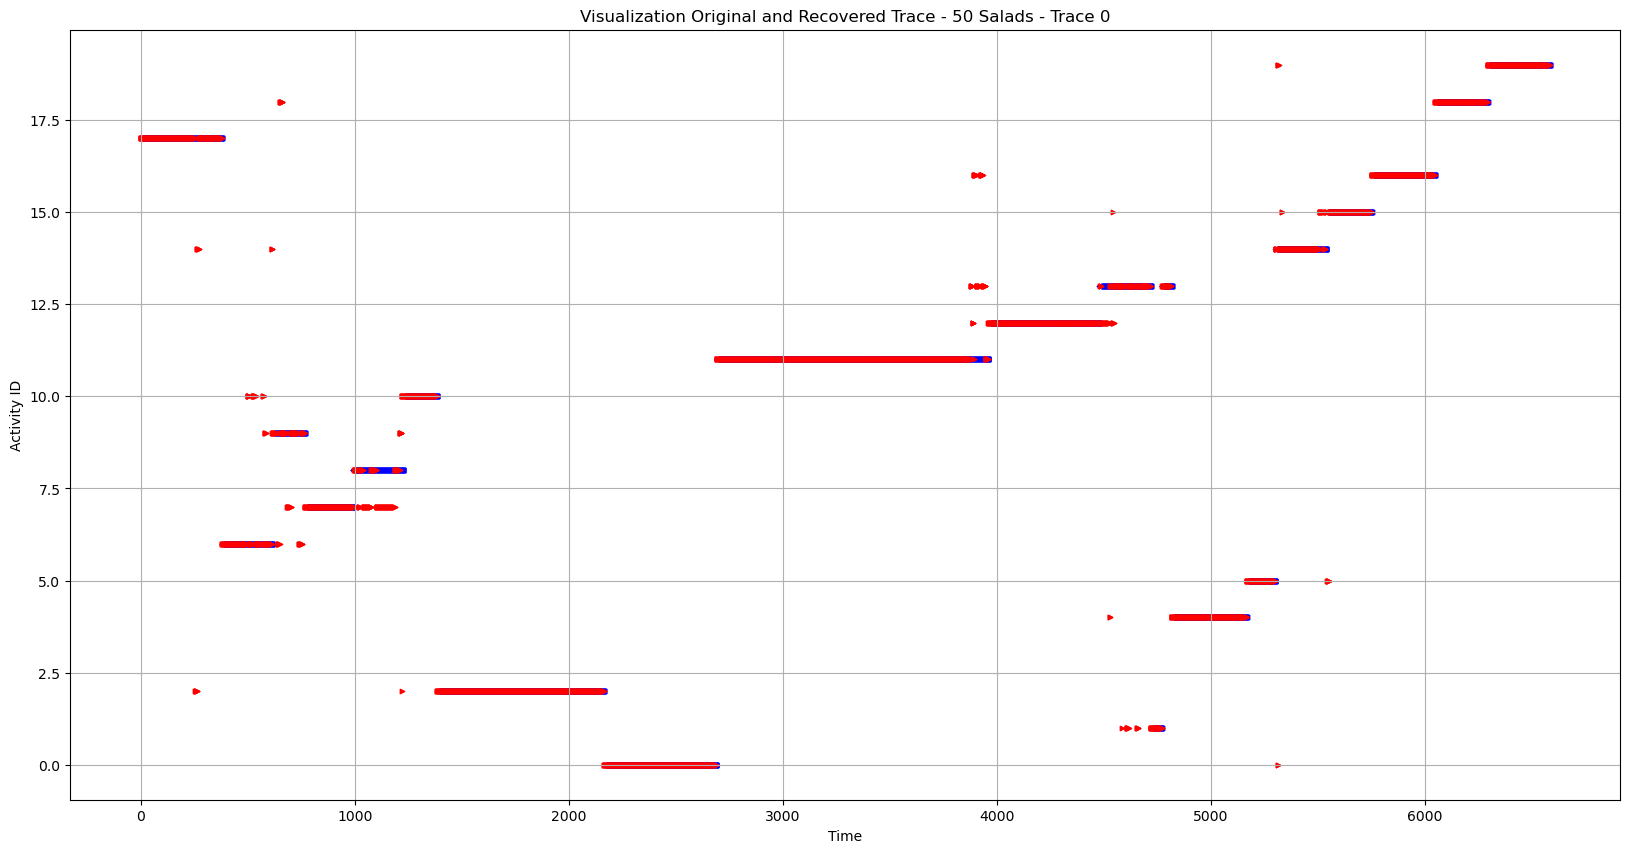

In [35]:
import matplotlib.pyplot as plt

i = random.choice(range(len(salads_original)))
original, recovered, amax = salads_original[i].to('cpu'), salads_recovered[i].to('cpu'), salads_argmax[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - 50 Salads - Trace {i}')
plt.grid(True)

plt.show()

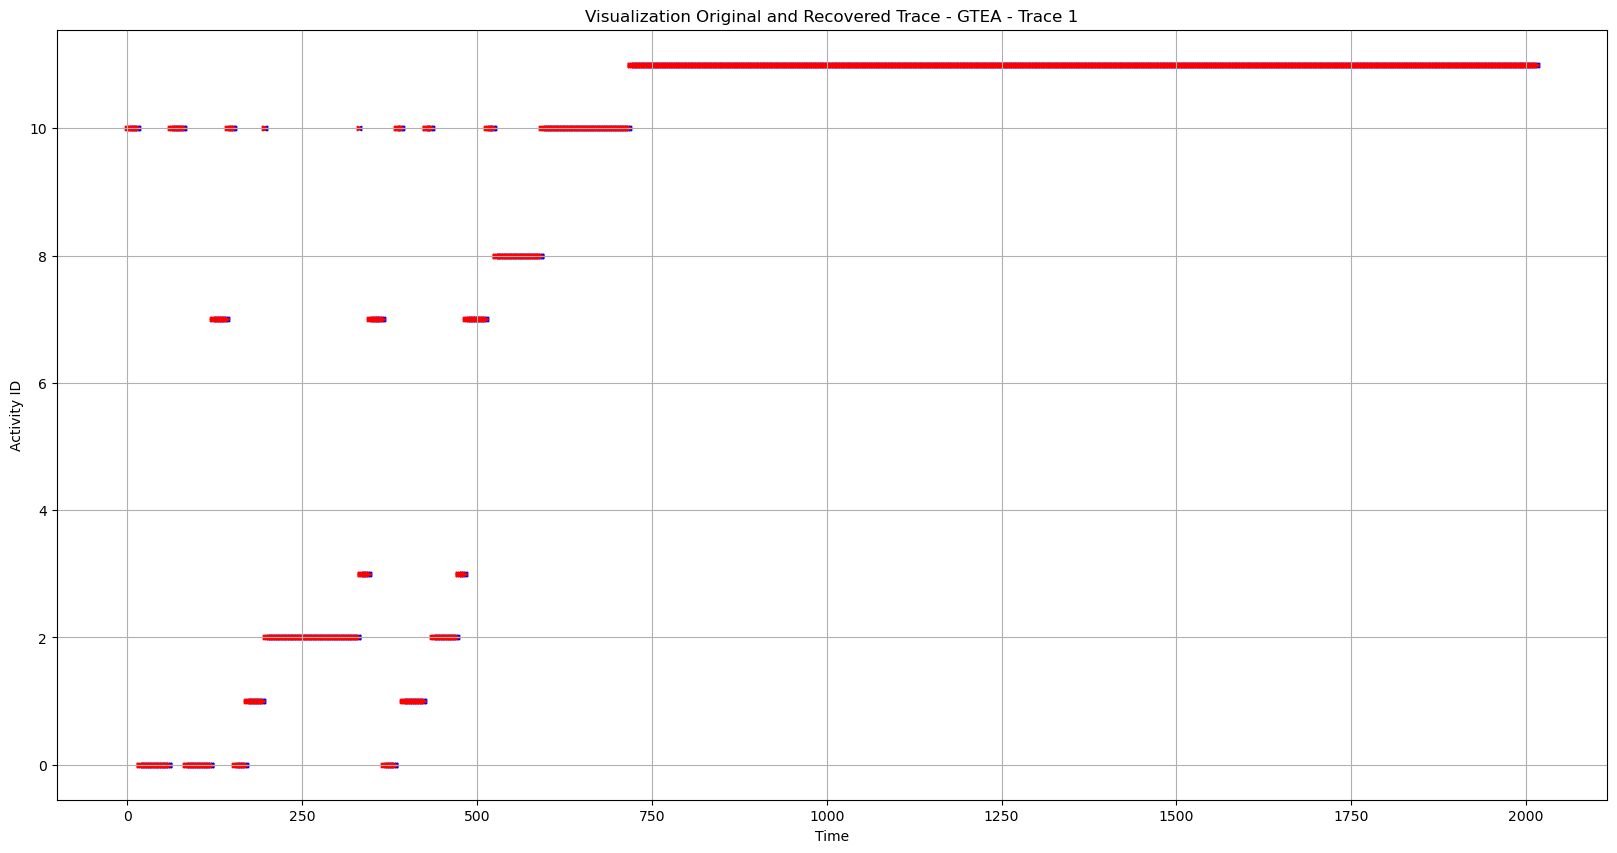

In [32]:
import matplotlib.pyplot as plt

i = random.choice(range(len(gtea_original)))
original, recovered = gtea_original[i].to('cpu'), gtea_recovered[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - GTEA - Trace {i}')
plt.grid(True)

plt.show()

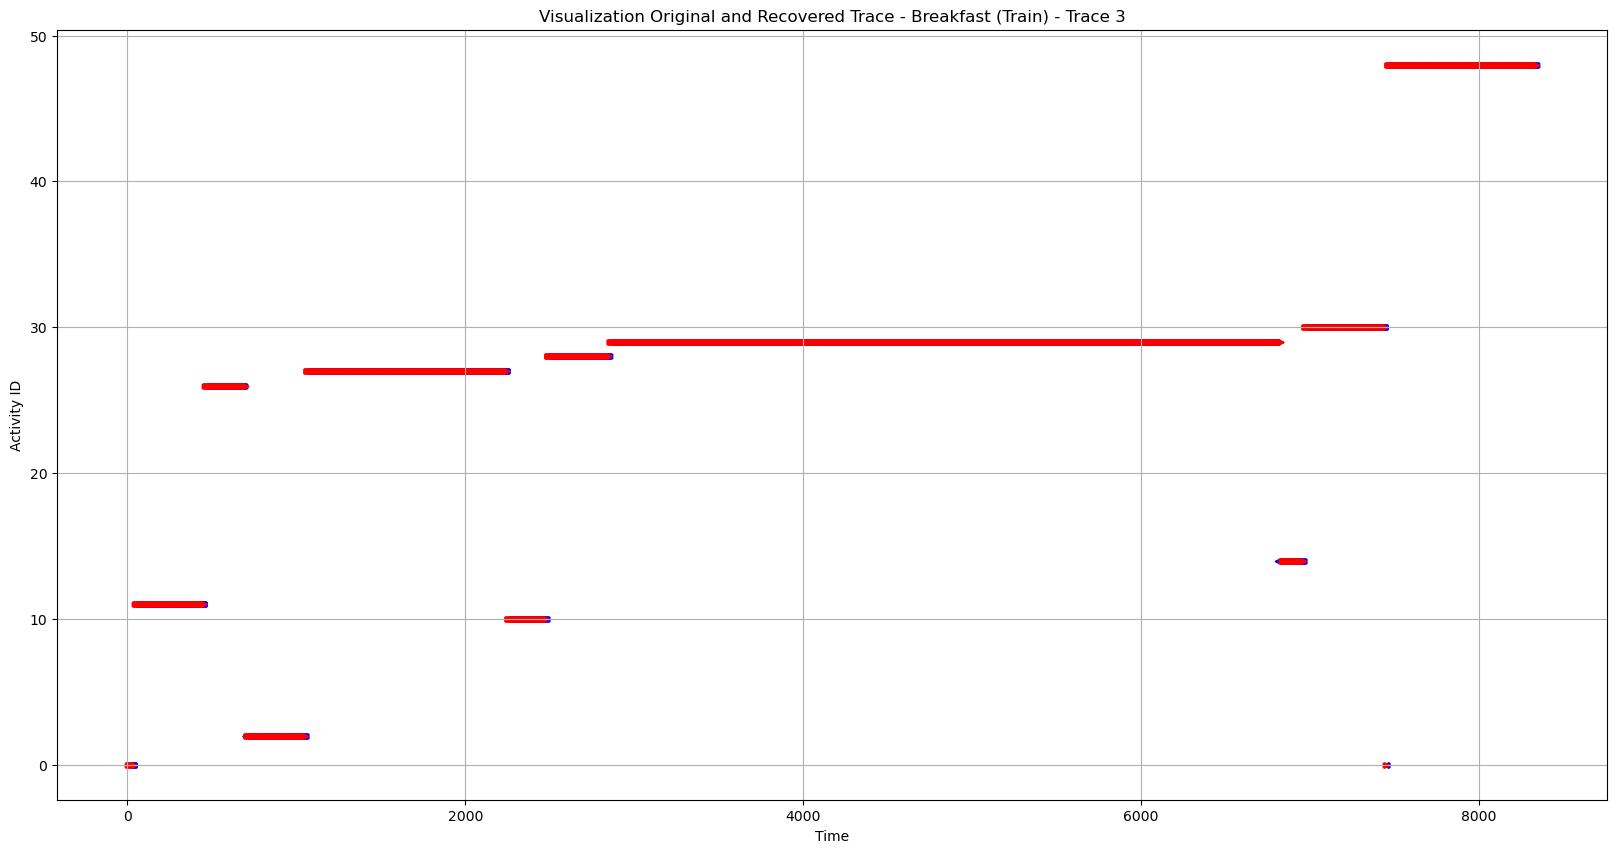

In [33]:
plt.show()
import matplotlib.pyplot as plt

i = random.choice(range(len(breakfast_original)))
original, recovered = breakfast_original[i].to('cpu'), breakfast_recovered[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - Breakfast (Train) - Trace {i}')
plt.grid(True)

plt.show()